In [1]:
import warnings
warnings.filterwarnings('ignore')

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [2]:
import pandas as pd
import nltk
import re
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense
from tensorflow.keras import layers
from keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [3]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/manoj.peta/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/manoj.peta/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [4]:
df = pd.read_csv('yelp_review_train.csv')

df.head()

,text,stars
0,Went for lunch and found that my burger was me...,2.0
1,I needed a new tires for my wife's car. They h...,5.0
2,Jim Woltman who works at Goleta Honda is 5 sta...,5.0
3,Been here a few times to get some shrimp. The...,4.0
4,This is one fantastic place to eat whether you...,5.0


# Preprocessing

In [5]:
def convert_sentiment(stars):
    if stars > 3:
        return 'Positive'
    elif stars <= 2:
        return 'Negative'
    else:
        return 'Neutral'

df['stars'] = df['stars'].apply(convert_sentiment)

df.head()

,text,stars
0,Went for lunch and found that my burger was me...,Negative
1,I needed a new tires for my wife's car. They h...,Positive
2,Jim Woltman who works at Goleta Honda is 5 sta...,Positive
3,Been here a few times to get some shrimp. The...,Positive
4,This is one fantastic place to eat whether you...,Positive


In [6]:
from nltk.corpus import stopwords

def preprocess_data(text):
    text = re.sub(r'[^\w\s]', '', text)                                         # removing punctuation
    text = text.lower()                                                         # converting to lower case

    stop_words = set(stopwords.words('english'))                                # removing stop words
    tokens = nltk.word_tokenize(text)
    filtered_text = [word for word in tokens if word.lower() not in stop_words]

    return ' '.join(filtered_text)

In [7]:
df['text'] = df['text'].apply(preprocess_data)

df.head()

,text,stars
0,went lunch found burger meh obvious focus burg...,Negative
1,needed new tires wifes car special order next ...,Positive
2,jim woltman works goleta honda 5 stars knowled...,Positive
3,times get shrimp theyve got nice selection dif...,Positive
4,one fantastic place eat whether hungry need go...,Positive


In [8]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(df['stars'])

# Input data preparation

In [9]:
average_length  = df['text'].apply(len).mean()
min_length      = df['text'].apply(len).min()
max_length      = df['text'].apply(len).max()


print(average_length)
print(min_length)
print(max_length)

356.48578883821534
6
3612


In [10]:
sequence_length = 500

In [11]:
def word_count(dataset):
    word_counts = {}
    for sentence in dataset['text']:
        for word in sentence.split():
            word_counts[word] = word_counts.get(word, 0) + 1
    return word_counts


input_word_counts = word_count(df)
input_word_counts = dict(sorted(input_word_counts.items(), key=lambda item: item[1], reverse=True))
num_distinct_input_words = len(input_word_counts)
vocab_size = num_distinct_input_words

print("Number of distinct words in input dataset:", num_distinct_input_words)

Number of distinct words in input dataset: 148259


In [12]:
input_vectorization = layers.TextVectorization(
                                                max_tokens = 30000,
                                                output_mode = "int",
                                                output_sequence_length = sequence_length,
                                                standardize = None,
                                            )

input_vectorization.adapt(df['text'])

# Transformer implementation

In [13]:
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, latent_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.latent_dim = latent_dim
        self.num_heads = num_heads
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.dense_proj = keras.Sequential(
            [
                layers.Dense(latent_dim, activation="relu"),
                layers.Dense(embed_dim),
            ]
        )
        self.layernorm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.supports_masking = True

    def call(self, inputs, mask=None):
        attention_output = self.attention(query=inputs, value=inputs, key=inputs)
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "embed_dim": self.embed_dim,
                "latent_dim": self.latent_dim,
                "num_heads": self.num_heads,
            }
        )
        return config

In [14]:
class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, vocab_size, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.token_embeddings = layers.Embedding(
            input_dim=vocab_size, output_dim=embed_dim
        )
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=embed_dim
        )
        self.sequence_length = sequence_length
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "sequence_length": self.sequence_length,
                "vocab_size": self.vocab_size,
                "embed_dim": self.embed_dim,
            }
        )
        return config

In [15]:
import numpy as np

train_text = np.array(df['text'])
train_text = input_vectorization(train_text)

In [16]:
configurations = [
    {"num_layers": 1, "embed_dim": 32,  "num_heads": 2,  "latent_dim": 32,  "dropout_rate": 0.1, "epochs": 20},
    {"num_layers": 2, "embed_dim": 64,  "num_heads": 4,  "latent_dim": 64,  "dropout_rate": 0.2, "epochs": 20},
    {"num_layers": 3, "embed_dim": 128, "num_heads": 6,  "latent_dim": 128, "dropout_rate": 0.3, "epochs": 20},
    {"num_layers": 4, "embed_dim": 256, "num_heads": 8,  "latent_dim": 256, "dropout_rate": 0.4, "epochs": 20},
    {"num_layers": 5, "embed_dim": 512, "num_heads": 10, "latent_dim": 512, "dropout_rate": 0.5, "epochs": 1}
]

history_all = []

Epoch 1/20


I0000 00:00:1702415194.252190  190611 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


4368/4369 [============================>.] - ETA: 0s - loss: 0.3835 - accuracy: 0.8552
Epoch 1: val_accuracy improved from -inf to 0.86770, saving model to ml_transformer_layers_1_embed_dim32_heads2_latent_dim32_dropout10.h5
4369/4369 [==============================] - 205s 45ms/step - loss: 0.3834 - accuracy: 0.8552 - val_loss: 0.3401 - val_accuracy: 0.8677 - lr: 0.0010
Epoch 2/20
4365/4369 [============================>.] - ETA: 0s - loss: 0.3051 - accuracy: 0.8825
Epoch 2: val_accuracy improved from 0.86770 to 0.86793, saving model to ml_transformer_layers_1_embed_dim32_heads2_latent_dim32_dropout10.h5
4369/4369 [==============================] - 66s 15ms/step - loss: 0.3050 - accuracy: 0.8826 - val_loss: 0.3520 - val_accuracy: 0.8679 - lr: 0.0010
Epoch 3/20
4367/4369 [============================>.] - ETA: 0s - loss: 0.2665 - accuracy: 0.8954
Epoch 3: val_accuracy did not improve from 0.86793
4369/4369 [==============================] - 59s 13ms/step - loss: 0.2665 - accuracy: 0.89

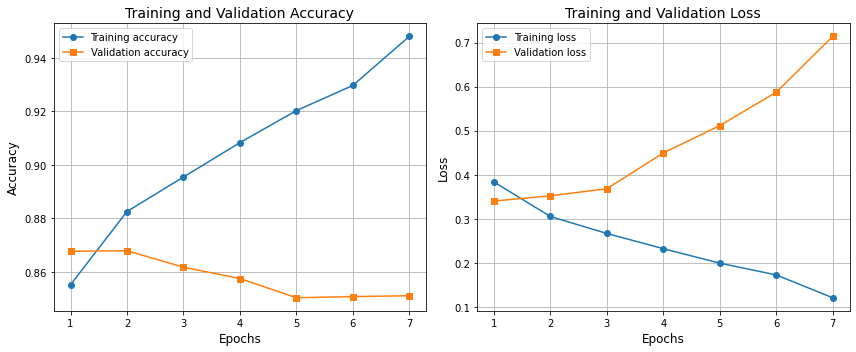

Epoch 1/20
4368/4369 [============================>.] - ETA: 0s - loss: 0.3919 - accuracy: 0.8537
Epoch 1: val_accuracy improved from -inf to 0.86461, saving model to ml_transformer_layers_2_embed_dim64_heads4_latent_dim64_dropout20.h5
4369/4369 [==============================] - 270s 60ms/step - loss: 0.3919 - accuracy: 0.8537 - val_loss: 0.3515 - val_accuracy: 0.8646 - lr: 0.0010
Epoch 2/20
4367/4369 [============================>.] - ETA: 0s - loss: 0.3128 - accuracy: 0.8798
Epoch 2: val_accuracy did not improve from 0.86461
4369/4369 [==============================] - 102s 23ms/step - loss: 0.3129 - accuracy: 0.8798 - val_loss: 0.3559 - val_accuracy: 0.8630 - lr: 0.0010
Epoch 3/20
4368/4369 [============================>.] - ETA: 0s - loss: 0.2747 - accuracy: 0.8940
Epoch 3: val_accuracy did not improve from 0.86461
4369/4369 [==============================] - 95s 22ms/step - loss: 0.2746 - accuracy: 0.8940 - val_loss: 0.3738 - val_accuracy: 0.8601 - lr: 0.0010
Epoch 4/20
4368/4369

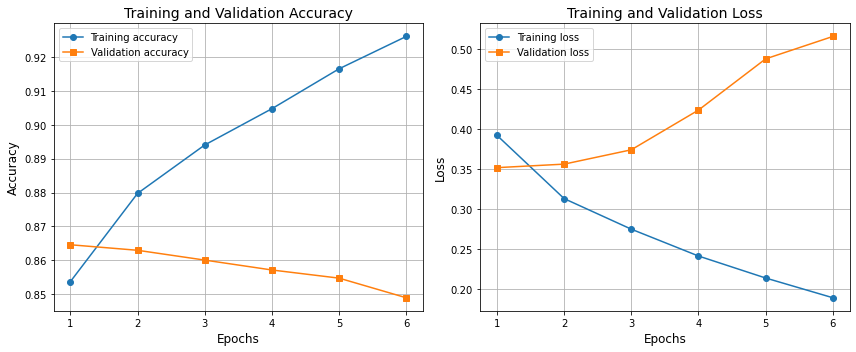

Epoch 1/20
4368/4369 [============================>.] - ETA: 0s - loss: 0.4350 - accuracy: 0.8411
Epoch 1: val_accuracy improved from -inf to 0.85446, saving model to ml_transformer_layers_3_embed_dim128_heads6_latent_dim128_dropout30.h5
4369/4369 [==============================] - 253s 56ms/step - loss: 0.4350 - accuracy: 0.8411 - val_loss: 0.3883 - val_accuracy: 0.8545 - lr: 0.0010
Epoch 2/20
4368/4369 [============================>.] - ETA: 0s - loss: 0.3773 - accuracy: 0.8579
Epoch 2: val_accuracy did not improve from 0.85446
4369/4369 [==============================] - 196s 45ms/step - loss: 0.3773 - accuracy: 0.8579 - val_loss: 0.4719 - val_accuracy: 0.8344 - lr: 0.0010
Epoch 3/20
4368/4369 [============================>.] - ETA: 0s - loss: 0.4018 - accuracy: 0.8526
Epoch 3: val_accuracy did not improve from 0.85446
4369/4369 [==============================] - 192s 44ms/step - loss: 0.4018 - accuracy: 0.8526 - val_loss: 0.4359 - val_accuracy: 0.8401 - lr: 0.0010
Epoch 4/20
4368/4

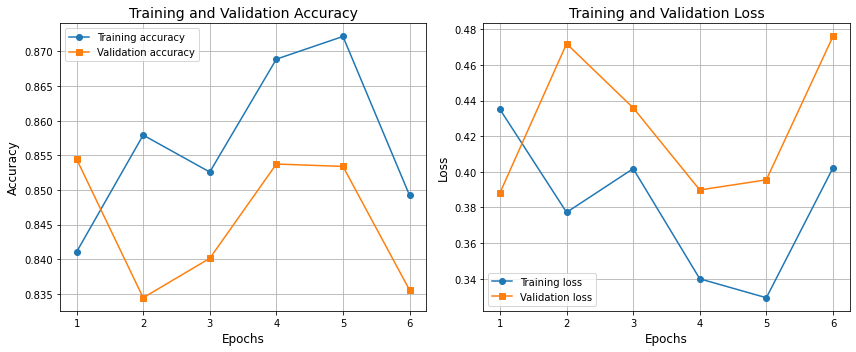

Epoch 1/20
4369/4369 [==============================] - ETA: 0s - loss: 0.8508 - accuracy: 0.6689
Epoch 1: val_accuracy improved from -inf to 0.67178, saving model to ml_transformer_layers_4_embed_dim256_heads8_latent_dim256_dropout40.h5
4369/4369 [==============================] - 608s 136ms/step - loss: 0.8508 - accuracy: 0.6689 - val_loss: 0.8369 - val_accuracy: 0.6718 - lr: 0.0010
Epoch 2/20
4369/4369 [==============================] - ETA: 0s - loss: 0.8385 - accuracy: 0.6702
Epoch 2: val_accuracy did not improve from 0.67178
4369/4369 [==============================] - 575s 132ms/step - loss: 0.8385 - accuracy: 0.6702 - val_loss: 0.8342 - val_accuracy: 0.6718 - lr: 0.0010
Epoch 3/20
4369/4369 [==============================] - ETA: 0s - loss: 0.8357 - accuracy: 0.6702
Epoch 3: val_accuracy did not improve from 0.67178
4369/4369 [==============================] - 579s 133ms/step - loss: 0.8357 - accuracy: 0.6702 - val_loss: 0.8336 - val_accuracy: 0.6718 - lr: 0.0010
Epoch 4/20
436

In [ ]:
from keras.layers import GlobalAveragePooling1D, Dropout, Dense
from tensorflow.keras.layers import GlobalAveragePooling1D, Dropout, Dense
from keras.models import Model
import matplotlib.pyplot as plt


for model_config in configurations:
  encoder_inputs = keras.Input(shape=(500,), dtype="int64", name="encoder_inputs")
  x = PositionalEmbedding(sequence_length, vocab_size, model_config["embed_dim"])(encoder_inputs)
    
  for i in range(model_config["num_layers"]):
      x = TransformerEncoder(model_config["embed_dim"], model_config["latent_dim"], model_config["num_heads"])(x)
  dropout_rate = model_config['dropout_rate']

  x = GlobalAveragePooling1D()(x)
  x = Dropout(dropout_rate)(x)
  x = Dense(model_config["embed_dim"], activation="relu")(x)
  x = Dropout(dropout_rate)(x)
  outputs = Dense(3, activation="softmax")(x)
  model = Model(inputs=encoder_inputs, outputs=outputs)

  checkpoint_file_name = f"ml_transformer_layers_{model_config['num_layers']}_embed_dim{model_config['embed_dim']}_heads{model_config['num_heads']}_latent_dim{model_config['latent_dim']}_dropout{int(dropout_rate*100)}.h5"

  callbacks = [tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1),
              tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, verbose=1, restore_best_weights=True),
              tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_file_name, save_best_only=True, monitor="val_accuracy", verbose=1)]


  model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])


  history = model.fit(train_text, y_train_encoded, epochs=model_config['epochs'], batch_size=32, validation_split=0.2, callbacks=callbacks)

  accuracy = history.history["accuracy"]
  val_accuracy = history.history["val_accuracy"]
  loss = history.history["loss"]
  val_loss = history.history["val_loss"]
  epochs = range(1, len(accuracy) + 1)

  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

  training_line_color = '#1f77b4' 
  validation_line_color = '#ff7f0e'

  ax1.plot(epochs, accuracy, marker='o', color=training_line_color, label="Training accuracy")
  ax1.plot(epochs, val_accuracy, marker='s', color=validation_line_color, label="Validation accuracy")
  ax1.set_title("Training and Validation Accuracy", fontsize=14)
  ax1.set_xlabel("Epochs", fontsize=12)
  ax1.set_ylabel("Accuracy", fontsize=12)
  ax1.legend()
  ax1.grid(True)

  ax2.plot(epochs, loss, marker='o', color=training_line_color, label="Training loss")
  ax2.plot(epochs, val_loss, marker='s', color=validation_line_color, label="Validation loss")
  ax2.set_title("Training and Validation Loss", fontsize=14)
  ax2.set_xlabel("Epochs", fontsize=12)
  ax2.set_ylabel("Loss", fontsize=12)
  ax2.legend()
  ax2.grid(True)

  plt.tight_layout()
  plt.show()

In [ ]:
df_test = pd.read_csv('yelp_review_test.csv')

df_test.head()

In [ ]:
df_test['stars'] = df_test['stars'].apply(convert_sentiment)

df_test.head()

In [ ]:
df_test['text'] = df_test['text'].apply(preprocess_data)

df_test.head()

In [ ]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y_test_encoded = label_encoder.fit_transform(df_test['stars'])

In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import custom_object_scope
import numpy as np


test_text = np.array(df_test['text'])
test_text = input_vectorization(test_text)


with custom_object_scope({'PositionalEmbedding': PositionalEmbedding, 'TransformerEncoder': TransformerEncoder}):
    best_model = load_model("ml_transformer_layers_1_embed_dim32_heads2_latent_dim32_dropout10.h5")


test_loss, test_accuracy = best_model.evaluate(test_text, y_test_encoded)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assume 'predictions' is an array of your model's predictions
predictions = best_model.predict(test_text)
predicted_classes = np.argmax(predictions, axis=1)

# Generating the confusion matrix
cm = confusion_matrix(y_test_encoded, predicted_classes)

# Plotting the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [ ]:
# Obtaining prediction probabilities
prediction_probabilities = best_model.predict(test_text)

In [ ]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from itertools import cycle

n_classes = 3

# Assuming y_test_encoded is your test labels and n_classes is the number of classes
y_test_binarized = label_binarize(y_test_encoded, classes=[*range(n_classes)])

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], prediction_probabilities[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plotting
plt.figure(figsize=(8, 6))
colors = cycle(['blue', 'red', 'green'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC and AUC')
plt.legend(loc="lower right")
plt.show()

As number of attention layers increases, model tends to overfit. Transformer is very power and even with one encoding layer and 2 attention heads, model was able to achieve a performace of 87%. But as number of encoding layers, attention heads increases it tends to overfit.